# Display Buffered Segment Popularity Vectors

This notebook loads the buffered segment popularity vector GeoPackage files generated by the `Segments` feature task and displays them on an interactive Folium map.

In [1]:
import geopandas as gpd
import folium
from pathlib import Path
import glob
import os
import warnings

# Ignore specific warnings if needed (e.g., ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning) # Geopandas future warnings
warnings.filterwarnings("ignore", message="Geometry is in a geographic CRS.*") # Folium CRS warning

## Configuration

In [37]:
# --- Find the latest output directory --- 
# Go up two levels from helper directory to the base project directory
base_dir = Path.cwd().parent 
output_parent_dir = base_dir / "output"

# Find all directories matching the pattern 'mca_YYYYMMDD_HHMM'
potential_dirs = sorted(
    [d for d in output_parent_dir.glob("mca_*") if d.is_dir()], 
    key=os.path.getmtime,
    reverse=True
)

if not potential_dirs:
    raise FileNotFoundError(f"No output directories found in {output_parent_dir}")

latest_output_dir = potential_dirs[0]
print(f"Using latest output directory: {latest_output_dir}")

# --- Define the file pattern for the vector files ---
vector_file_pattern = "segment_popularity_vector_*.gpkg"
vector_files = sorted(latest_output_dir.glob(vector_file_pattern))

if not vector_files:
    print(f"WARNING: No vector files matching '{vector_file_pattern}' found in {latest_output_dir}")
else:
    print(f"Found {len(vector_files)} vector files:")
    for f in vector_files:
        print(f" - {f.name}")

Using latest output directory: /Users/per.morten.halvorsen@schibsted.com/uio/geo4460/mca/output/mca_20250420_1107
Found 4 vector files:
 - segment_popularity_vector_athletes_per_age.gpkg
 - segment_popularity_vector_efforts_per_age.gpkg
 - segment_popularity_vector_stars_per_age.gpkg
 - segment_popularity_vector_stars_per_athlete.gpkg


## Load and Display Vectors

In [48]:
from branca.colormap import linear


def color_function(value):
    """
    Function to determine the color based on the value.
    """
    def _grey_hex_to_decimal(hex_color):
        """
        Convert a grey hex color to its decimal RGB values.
        """
        hex_color = hex_color.replace("#", "")
        int_value = int(hex_color[0:2], 16)
        return int_value/255

    return linear.viridis.scale(0, 1)(_grey_hex_to_decimal(value))


if vector_files:
    # --- Create Base Map --- 
    # Load the first file to get bounds for centering the map
    try:
        first_gdf = gpd.read_file(vector_files[0])
        # Reproject to WGS84 for Folium
        first_gdf_wgs84 = first_gdf.to_crs(epsg=4326)
        map_center = first_gdf_wgs84.geometry.unary_union.centroid.coords[0][::-1] # Reverse (lat, lon)
        m = folium.Map(location=map_center, zoom_start=12, tiles='CartoDB positron')
    except Exception as e:
        print(f"Error loading first file {vector_files[0]} to center map: {e}. Creating default map.")
        m = folium.Map(location=[59.9139, 10.7522], zoom_start=11, tiles='CartoDB positron') # Default Oslo center

    # --- Add each vector file as a layer --- 
    for vector_file in vector_files:
        if "_" not in vector_file.name:
            print(f"Skipping {vector_file.name}...")
            continue
        try:
            print(f"Processing {vector_file.name}...")
            gdf = gpd.read_file(vector_file)
            # print(gdf.describe())
            
            # Ensure it has geometry and the color column
            if gdf.empty or 'geometry' not in gdf.columns or 'color' not in gdf.columns:
                print(f" - Skipping {vector_file.name}: Empty or missing required columns ('geometry', 'color').")
                continue
                
            # Find the metric column name (the one before '_norm')
            metric_col = None
            norm_col = None
            for col in gdf.columns:
                if col.endswith('_norm'):
                    norm_col = col
                    metric_col = col[:-5] # Remove '_norm'
                    break
            
            if not metric_col or metric_col not in gdf.columns:
                 print(f" - Skipping {vector_file.name}: Could not determine metric column name.")
                 continue
            
            # Reproject to WGS84 for Folium
            gdf_wgs84 = gdf.to_crs(epsg=4326)
            

            # Define style function to use the 'color' column
            def style_function(x):
                # Use the 'color' property from the GeoJSON feature
                color = x['properties']['color']
                # Replace greyscale with a more colorful palette
                return {
                    'fillColor': color_function(color),
                    'color': color_function(color),  # Border color same as fill
                    'weight': 5,
                    'fillOpacity': 0.7
                }

            
            # Define tooltip fields
            tooltip_fields = [metric_col, norm_col]
            tooltip_aliases = [f"{metric_col.replace('_',' ').title()}:", "Log-Normalized:"]
            
            # Add to map
            layer_name = metric_col.replace('_', ' ').title()
            geojson_layer = folium.GeoJson(
                gdf_wgs84,
                name=layer_name,
                style_function=style_function,
                tooltip=folium.features.GeoJsonTooltip(
                    fields=tooltip_fields,
                    aliases=tooltip_aliases,
                    localize=True,
                    sticky=False,
                    labels=True,
                    style="""
                        background-color: #F0EFEF;
                        border: 2px solid black;
                        border-radius: 3px;
                        box-shadow: 3px;
                    """,
                    max_width=800,
                ),
                show=(vector_file == vector_files[0])  # Show first layer by default
            )
            
            
            geojson_layer.add_to(m)
            print(f" - Added layer: {layer_name}")

        except Exception as e:
            print(f"Error processing file {vector_file.name}: {e}")

    # --- Add a colorbar ---
    colormap = linear.viridis.scale(0, 1)
    colormap.caption = "Log-Normalized metrics (0, 1)"
    colormap.add_to(m)
    # --- Add Layer Control and Display Map ---
    folium.LayerControl().add_to(m)
    display(m)

else:
    print("No vector files found to display.")


/var/folders/9t/2ktxww317sjf49by2n8qnpb80000gp/T/ipykernel_92024/873343642.py:26: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  map_center = first_gdf_wgs84.geometry.unary_union.centroid.coords[0][::-1] # Reverse (lat, lon)


Processing segment_popularity_vector_athletes_per_age.gpkg...
 - Added layer: Athletes Per Age
Processing segment_popularity_vector_efforts_per_age.gpkg...
 - Added layer: Efforts Per Age
Processing segment_popularity_vector_stars_per_age.gpkg...
 - Added layer: Stars Per Age
Processing segment_popularity_vector_stars_per_athlete.gpkg...
 - Added layer: Stars Per Athlete


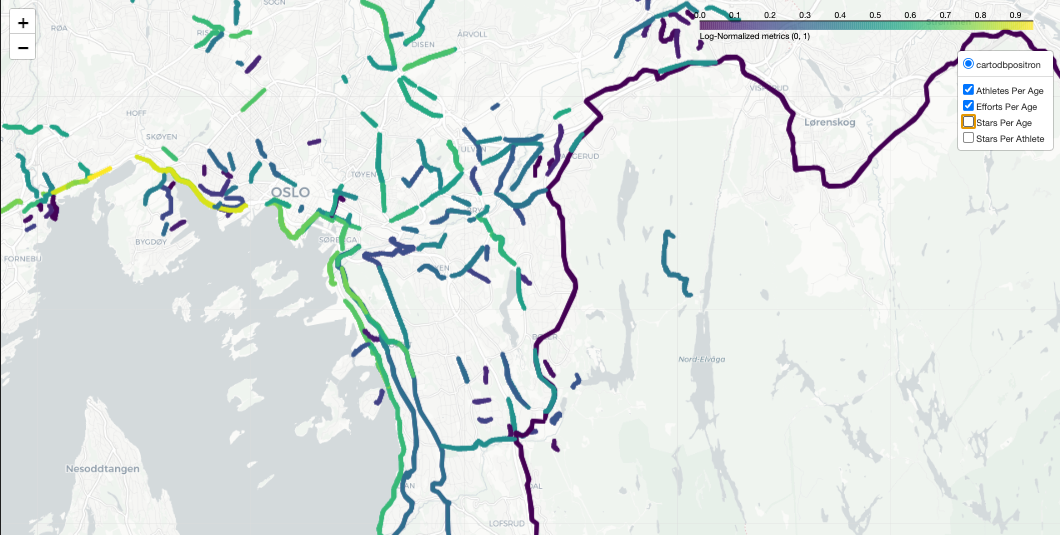

It seems efforts per age might be the best way to represent popularity. 